# Telecom Churn Prediction 

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno
#pip install imblearn
#!pip install sidetable
#!pip install xgboost

#Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import KFold
from sklearn import svm
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import sidetable
from tabulate import tabulate

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_rows', None)

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [2]:
#load data
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [3]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [4]:
#Make a copy of the data
df = data.copy()
df.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


# 2. Data Cleaning and Imputation

## 2.1 Data Understanding and Cleaning

In [5]:
# find out missing/ null values
percent_missing = (df.isnull().sum()/df.shape[0]) *100
percent_missing.sort_values(inplace=True,ascending=False)
percent_missing

arpu_3g_6                   74.902499
count_rech_2g_6             74.902499
night_pck_user_6            74.902499
arpu_2g_6                   74.902499
date_of_last_rech_data_6    74.902499
total_rech_data_6           74.902499
av_rech_amt_data_6          74.902499
max_rech_data_6             74.902499
count_rech_3g_6             74.902499
fb_user_6                   74.902499
night_pck_user_7            74.478207
date_of_last_rech_data_7    74.478207
total_rech_data_7           74.478207
max_rech_data_7             74.478207
fb_user_7                   74.478207
count_rech_2g_7             74.478207
count_rech_3g_7             74.478207
arpu_3g_7                   74.478207
av_rech_amt_data_7          74.478207
arpu_2g_7                   74.478207
count_rech_2g_8             73.689624
av_rech_amt_data_8          73.689624
night_pck_user_8            73.689624
max_rech_data_8             73.689624
total_rech_data_8           73.689624
arpu_2g_8                   73.689624
arpu_3g_8   

In [6]:
#Find list of columns having more than 60% null
col_to_drop = percent_missing[percent_missing > 60].keys()

In [7]:
#Drop column more than 60% null value
for col in col_to_drop:
    del df[col]

In [8]:
#Get least distinctive / less varaince feature
leastdisc= []
for col in df:
    if df[col].unique().size < 5:
        leastdisc.append(col)

for col in leastdisc:
    print(df[col].value_counts())

109    69999
Name: circle_id, dtype: int64
0.0    69297
Name: loc_og_t2o_mou, dtype: int64
0.0    69297
Name: std_og_t2o_mou, dtype: int64
0.0    69297
Name: loc_ic_t2o_mou, dtype: int64
6/30/2014    69999
Name: last_date_of_month_6, dtype: int64
7/31/2014    69600
Name: last_date_of_month_7, dtype: int64
8/31/2014    69266
Name: last_date_of_month_8, dtype: int64
0.0    67231
Name: std_og_t2c_mou_6, dtype: int64
0.0    67312
Name: std_og_t2c_mou_7, dtype: int64
0.0    66296
Name: std_og_t2c_mou_8, dtype: int64
0.0    67231
Name: std_ic_t2o_mou_6, dtype: int64
0.0    67312
Name: std_ic_t2o_mou_7, dtype: int64
0.0    66296
Name: std_ic_t2o_mou_8, dtype: int64
0    62867
1     7132
Name: churn_probability, dtype: int64


In [9]:
# drop least distinctive columns 
leastdisc_col= ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
              'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6',
              'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'id']

for col in leastdisc_col:
    del df[col]

In [10]:
date_to_drop = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']
df.drop(date_to_drop, axis=1, inplace = True) 

In [11]:
# Find out high value customers 
df['arpu_Gphase'] = (df['arpu_6'] + df['arpu_7'])/2

In [12]:
# filter customer with ARPU more than 70 percentile 
high_value_filter = df['arpu_Gphase'].quantile(0.7)

df_high_val_cust = df[df['arpu_Gphase'] > high_value_filter]

In [13]:
df_high_val_cust.shape

(21000, 126)

Let's look at each variable's datatype:

In [14]:
df_high_val_cust.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 12 to 69990
Data columns (total 126 columns):
 #    Column              Dtype  
---   ------              -----  
 0    arpu_6              float64
 1    arpu_7              float64
 2    arpu_8              float64
 3    onnet_mou_6         float64
 4    onnet_mou_7         float64
 5    onnet_mou_8         float64
 6    offnet_mou_6        float64
 7    offnet_mou_7        float64
 8    offnet_mou_8        float64
 9    roam_ic_mou_6       float64
 10   roam_ic_mou_7       float64
 11   roam_ic_mou_8       float64
 12   roam_og_mou_6       float64
 13   roam_og_mou_7       float64
 14   roam_og_mou_8       float64
 15   loc_og_t2t_mou_6    float64
 16   loc_og_t2t_mou_7    float64
 17   loc_og_t2t_mou_8    float64
 18   loc_og_t2m_mou_6    float64
 19   loc_og_t2m_mou_7    float64
 20   loc_og_t2m_mou_8    float64
 21   loc_og_t2f_mou_6    float64
 22   loc_og_t2f_mou_7    float64
 23   loc_og_t2f_mou_8    float64
 24  

Let's also summarize the features using the df.describe method:

In [15]:
df_high_val_cust.describe(include="all")

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,arpu_Gphase
count,21000.000000,21000.000000,21000.000000,20777.000000,20771.000000,20284.000000,20777.000000,20771.000000,20284.000000,20777.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,595.062539,590.576454,530.321718,302.712149,307.045096,274.882499,428.288871,427.042211,385.633853,17.708136,...,0.171857,0.143381,0.156143,0.145619,1268.835810,129.945662,135.942217,124.082008,0.090190,592.819496
std,453.857477,478.539413,511.647744,467.823291,489.602533,477.675127,468.337169,479.078139,473.597744,78.748558,...,0.578549,0.895228,0.998141,1.029419,974.420493,391.543864,409.330007,396.639863,0.286461,423.916500
min,-2041.228000,-1077.191000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000,317.497000
25%,374.194000,368.439250,286.350250,43.740000,42.085000,31.175000,144.680000,139.135000,106.280000,0.000000,...,0.000000,0.000000,0.000000,0.000000,480.000000,0.000000,0.000000,0.000000,0.000000,384.856625
50%,501.701000,495.156000,450.375000,130.690000,127.260000,105.270000,292.310000,285.330000,250.455000,0.000000,...,0.000000,0.000000,0.000000,0.000000,925.000000,0.000000,0.000000,0.000000,0.000000,487.112500
75%,707.986750,701.980250,667.315250,358.330000,358.925000,305.565000,537.430000,540.200000,492.242500,0.000000,...,0.000000,0.000000,0.000000,0.000000,1946.000000,4.295000,6.102500,0.000000,0.000000,675.178000
max,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,8362.360000,7043.980000,14007.340000,2613.310000,...,16.000000,29.000000,33.000000,41.000000,4321.000000,12916.220000,9165.600000,11166.210000,1.000000,31438.461000


## 2.2 Data Imputations

In [16]:
percent_missing = (df_high_val_cust.isnull().sum()/df_high_val_cust.shape[0]) *100
percent_missing.sort_values(inplace=True,ascending=False)
percent_missing[percent_missing > 0]
percent_missing.index

Index(['std_ic_t2t_mou_8', 'og_others_8', 'isd_og_mou_8', 'std_ic_mou_8',
       'loc_og_t2c_mou_8', 'std_ic_t2m_mou_8', 'loc_ic_t2f_mou_8',
       'loc_og_t2f_mou_8', 'spl_og_mou_8', 'std_og_t2t_mou_8',
       ...
       'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7',
       'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'last_day_rch_amt_6', 'last_day_rch_amt_7',
       'arpu_Gphase'],
      dtype='object', length=126)

In [17]:
num_col = df_high_val_cust.select_dtypes(include = ['int64','float64']).columns.tolist()
num_col.remove('churn_probability')

In [18]:
# Calling the Scaling function
scalar = MinMaxScaler()

# Scaling and transforming the data for the columns that are numerical
df_high_val_cust[num_col]=scalar.fit_transform(df_high_val_cust[num_col])

# Calling the KNN Imputer function
knn=KNNImputer(n_neighbors=3)

# Imputing the NaN values using KNN Imputer
df_high_val_cust_knn = pd.DataFrame(knn.fit_transform(df_high_val_cust[num_col]))
df_high_val_cust_knn.columns=df_high_val_cust[num_col].columns

In [19]:
df_high_val_cust[num_col]=scalar.inverse_transform(df_high_val_cust_knn)

In [20]:
df_high_val_cust.isnull().sum()

arpu_6                0
arpu_7                0
arpu_8                0
onnet_mou_6           0
onnet_mou_7           0
onnet_mou_8           0
offnet_mou_6          0
offnet_mou_7          0
offnet_mou_8          0
roam_ic_mou_6         0
roam_ic_mou_7         0
roam_ic_mou_8         0
roam_og_mou_6         0
roam_og_mou_7         0
roam_og_mou_8         0
loc_og_t2t_mou_6      0
loc_og_t2t_mou_7      0
loc_og_t2t_mou_8      0
loc_og_t2m_mou_6      0
loc_og_t2m_mou_7      0
loc_og_t2m_mou_8      0
loc_og_t2f_mou_6      0
loc_og_t2f_mou_7      0
loc_og_t2f_mou_8      0
loc_og_t2c_mou_6      0
loc_og_t2c_mou_7      0
loc_og_t2c_mou_8      0
loc_og_mou_6          0
loc_og_mou_7          0
loc_og_mou_8          0
std_og_t2t_mou_6      0
std_og_t2t_mou_7      0
std_og_t2t_mou_8      0
std_og_t2m_mou_6      0
std_og_t2m_mou_7      0
std_og_t2m_mou_8      0
std_og_t2f_mou_6      0
std_og_t2f_mou_7      0
std_og_t2f_mou_8      0
std_og_mou_6          0
std_og_mou_7          0
std_og_mou_8    

# 3. Data Visualization

In [21]:
df_high_val_cust['churn_probability'] = df_high_val_cust['churn_probability'].astype(int)
churned_customers = df_high_val_cust[df_high_val_cust['churn_probability'] == 1]
non_churned_customers = df_high_val_cust[df_high_val_cust['churn_probability'] == 0]

- __Age on Network V/s Churn Probability__

<AxesSubplot:xlabel='churn_probability', ylabel='aon'>

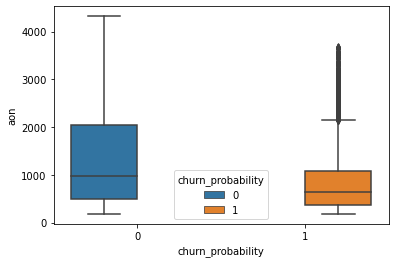

In [22]:
sns.boxplot(x='churn_probability', y ='aon', data=df_high_val_cust, hue ='churn_probability')

In [23]:
def num_univariate_analysis(column_names,scale='linear') : 
    # boxplot for column vs target
    
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(1,3,1)
    sns.boxplot(x='churn_probability', y = column_names[0], data = df_high_val_cust, ax=ax1)
    title = ''.join(column_names[0]) +' vs Churn'
    ax1.set(title=title)
    if scale == 'log' :
        plt.yscale('log')
        ax1.set(ylabel= column_names[0] + '(Log Scale)')
        
    ax2 = fig.add_subplot(1,3,2)
    sns.boxplot(x='churn_probability', y = column_names[1], data = df_high_val_cust, ax=ax2)
    title = ''.join(column_names[1]) +' vs Churn'
    ax2.set(title=title)
    if scale == 'log' :
        plt.yscale('log')
        ax2.set(ylabel= column_names[1] + '(Log Scale)')
    
    ax3 = fig.add_subplot(1,3,3)
    sns.boxplot(x='churn_probability', y = column_names[2], data = df_high_val_cust, ax=ax3)
    title = ''.join(column_names[2]) +' vs Churn'
    ax3.set(title=title)
    if scale == 'log' :
        plt.yscale('log')
        ax3.set(ylabel= column_names[2] + '(Log Scale)')
    
    # summary statistic
    
    print('Customers who churned (Churn : 1)')
    print(churned_customers[column_names].describe())
    
    print('\nCustomers who did not churn (Churn : 0)')
    print(non_churned_customers[column_names].describe(),'\n')

In [24]:
# function for categorical variable univariate analysis
def cat_univariate_analysis(column_names,figsize=(16,4)) : 
    
    # column vs target count plot
    fig = plt.figure(figsize=figsize)
    
    ax1 = fig.add_subplot(1,3,1)
    sns.countplot(x=column_names[0],hue='churn_probability',data=df_high_val_cust, ax=ax1)
    title = column_names[0] + ' vs No of Churned Customers'
    ax1.set(title= title)
    ax1.legend(loc='upper right')

    
    ax2 = fig.add_subplot(1,3,2)
    sns.countplot(x=column_names[1],hue='churn_probability',data=df_high_val_cust, ax=ax2)
    title = column_names[1] + ' vs No of Churned Customers'
    ax2.set(title= title)
    ax2.legend(loc='upper right')

        
    ax3 = fig.add_subplot(1,3,3)
    sns.countplot(x=column_names[2],hue='churn_probability',data=df_high_val_cust, ax=ax3)
    title = column_names[2] + ' vs No of Churned Customers'
    ax3.set(title= title)
    ax3.legend(loc='upper right')

        
    # Percentages 
    print('Customers who churned (Churn : 1)')
    print(tabulate(pd.DataFrame(churned_customers.stb.freq([column_names[0]])), headers='keys', tablefmt='psql'),'\n')
    print(tabulate(pd.DataFrame(churned_customers.stb.freq([column_names[1]])), headers='keys', tablefmt='psql'),'\n')
    print(tabulate(pd.DataFrame(churned_customers.stb.freq([column_names[2]])), headers='keys', tablefmt='psql'),'\n')

    print('\nCustomers who did not churn (Churn : 0)')
    print(tabulate(pd.DataFrame(non_churned_customers.stb.freq([column_names[0]])), headers='keys', tablefmt='psql'),'\n')
    print(tabulate(pd.DataFrame(non_churned_customers.stb.freq([column_names[1]])), headers='keys', tablefmt='psql'),'\n')
    print(tabulate(pd.DataFrame(non_churned_customers.stb.freq([column_names[2]])), headers='keys', tablefmt='psql'),'\n')

- __ARPU v/s Churn Probability__

Customers who churned (Churn : 1)
             arpu_6       arpu_7       arpu_8
count   1894.000000  1894.000000  1894.000000
mean     682.663537   537.212616   230.230143
std      564.423822   463.480550   366.259151
min     -209.465000   -97.096000  -155.236000
25%      412.924250   276.257500     0.000000
50%      581.435000   456.185500    93.017500
75%      817.295250   688.111000   328.919500
max    11505.508000  6876.324000  5228.826000

Customers who did not churn (Churn : 0)
             arpu_6        arpu_7        arpu_8
count  19106.000000  19106.000000  19106.000000
mean     586.378550    595.866473    560.070144
std      440.460639    479.694946    514.423203
min    -2041.228000  -1077.191000   -945.808000
25%      371.875250    373.823000    318.988750
50%      495.421000    497.825500    471.357500
75%      694.811750    703.107250    687.469250
max    27731.088000  35145.834000  33543.624000 



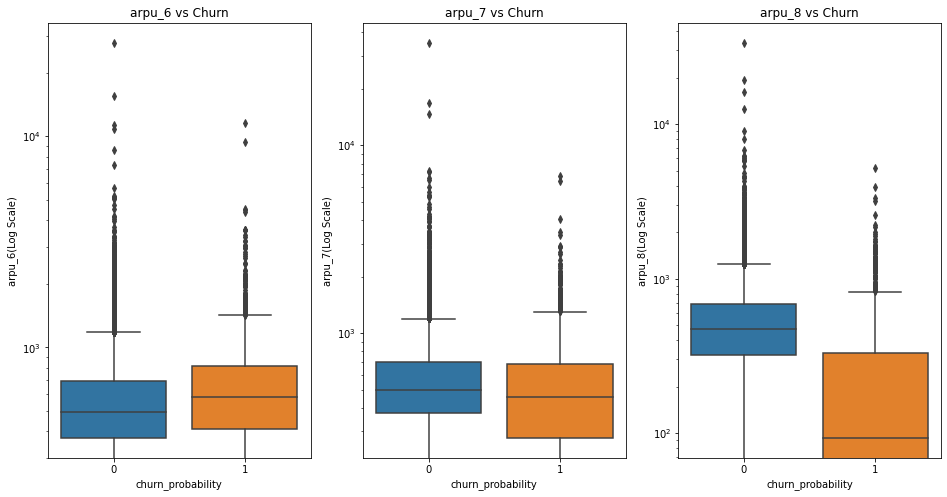

In [25]:
columns = ['arpu_6','arpu_7','arpu_8']
num_univariate_analysis(columns,'log')

- 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8' v/s Churn Probability

Customers who churned (Churn : 1)
       total_ic_mou_6  total_ic_mou_7  total_ic_mou_8
count     1894.000000     1894.000000     1894.000000
mean       238.427386      183.709784       63.241214
std        334.907019      295.087734      138.744735
min          0.000000        0.000000        0.000000
25%         49.585000       27.782500        0.000000
50%        137.725000       95.775000        0.000000
75%        288.967500      230.102500       64.412500
max       3493.860000     5137.560000     1480.640000

Customers who did not churn (Churn : 0)
       total_ic_mou_6  total_ic_mou_7  total_ic_mou_8
count    19106.000000    19106.000000    19106.000000
mean       315.069291      325.849645      316.165969
std        360.105430      368.364775      358.826210
min          0.000000        0.000000        0.000000
25%         95.872500      108.332500       99.340000
50%        212.720000      222.635000      214.495000
75%        404.595000      410.555000      401.602500
max    

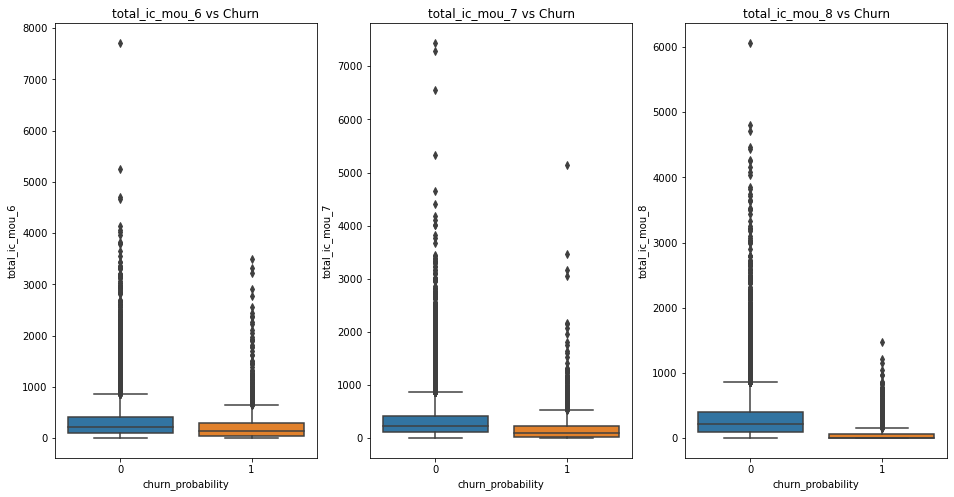

In [26]:
columns = ['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']
num_univariate_analysis(columns)

Customers who churned (Churn : 1)
       total_og_mou_6  total_og_mou_7  total_og_mou_8
count     1894.000000     1894.000000     1894.000000
mean       868.470533      665.159894      225.827672
std        838.691526      777.883721      480.197544
min          0.000000        0.000000        0.000000
25%        289.540000      102.877500        0.000000
50%        674.335000      439.485000        0.000000
75%       1208.870000      911.742500      239.117500
max       8488.360000     8285.640000     5206.210000

Customers who did not churn (Churn : 0)
       total_og_mou_6  total_og_mou_7  total_og_mou_8
count    19106.000000    19106.000000    19106.000000
mean       677.671818      710.985224      659.045048
std        637.996342      672.698965      689.128396
min          0.000000        0.000000        0.000000
25%        271.332500      283.995000      225.415000
50%        509.245000      528.110000      467.525000
75%        881.555000      928.002500      864.120000
max    

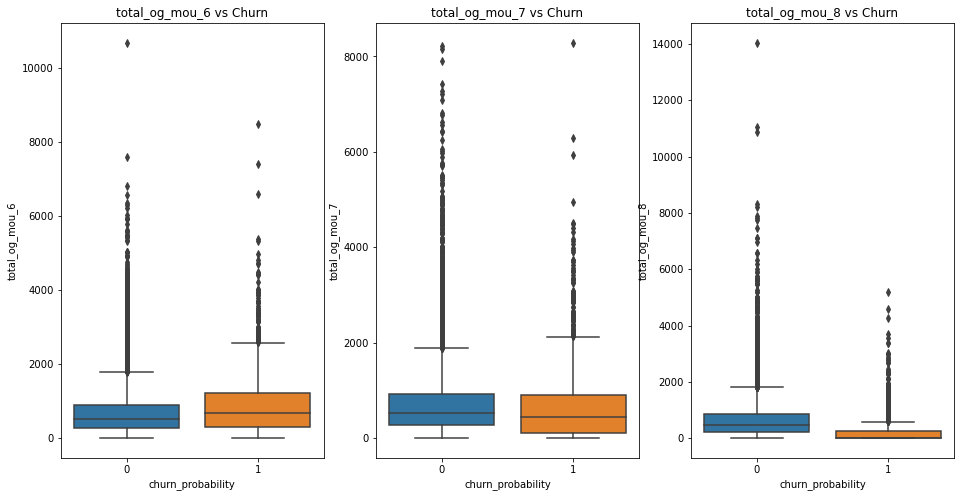

In [27]:
columns = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
num_univariate_analysis(columns)

Customers who churned (Churn : 1)
       vol_2g_mb_6  vol_2g_mb_7  vol_2g_mb_8
count  1894.000000  1894.000000  1894.000000
mean     53.858659    44.480201    14.790560
std     220.258474   197.191725   127.089568
min       0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000
50%       0.000000     0.000000     0.000000
75%       0.000000     0.000000     0.000000
max    4017.160000  3219.370000  3349.190000

Customers who did not churn (Churn : 0)
        vol_2g_mb_6   vol_2g_mb_7   vol_2g_mb_8
count  19106.000000  19106.000000  19106.000000
mean      80.685296     81.247796     75.301079
std      281.137704    283.184187    281.315368
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000
75%       17.910000     19.080000     14.870000
max    10285.900000   7873.550000  11117.610000 



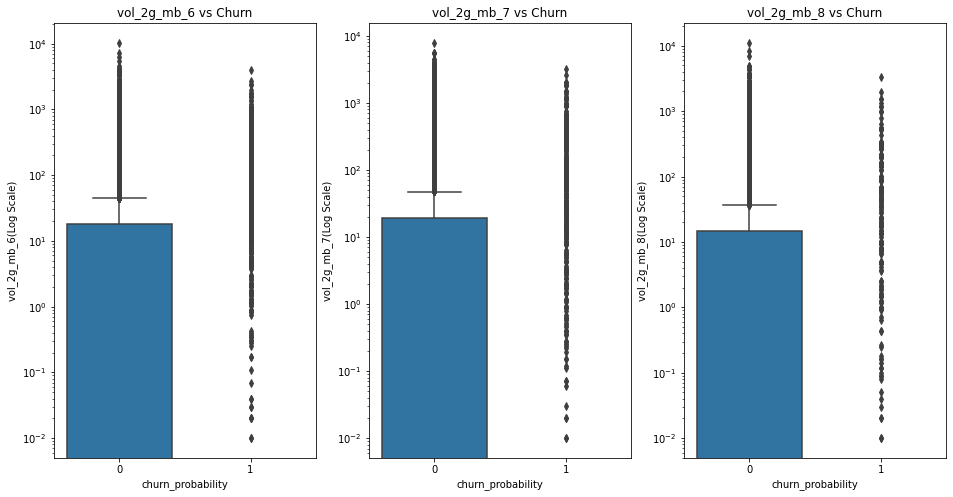

In [28]:
columns = ['vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8']
num_univariate_analysis(columns, 'log')

Customers who churned (Churn : 1)
       vol_3g_mb_6   vol_3g_mb_7   vol_3g_mb_8
count  1894.000000   1894.000000   1894.000000
mean    201.917091    149.591457     57.966199
std     770.400192    715.169367    482.153108
min       0.000000      0.000000      0.000000
25%       0.000000      0.000000      0.000000
50%       0.000000      0.000000      0.000000
75%       0.000000      0.000000      0.000000
max    9400.120000  15115.510000  13440.720000

Customers who did not churn (Churn : 0)
        vol_3g_mb_6   vol_3g_mb_7   vol_3g_mb_8
count  19106.000000  19106.000000  19106.000000
mean     270.251722    295.063151    291.636295
std      897.319191    899.029691    897.152947
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000
75%        0.277500     48.230000     40.837500
max    45735.400000  28144.120000  30036.060000 



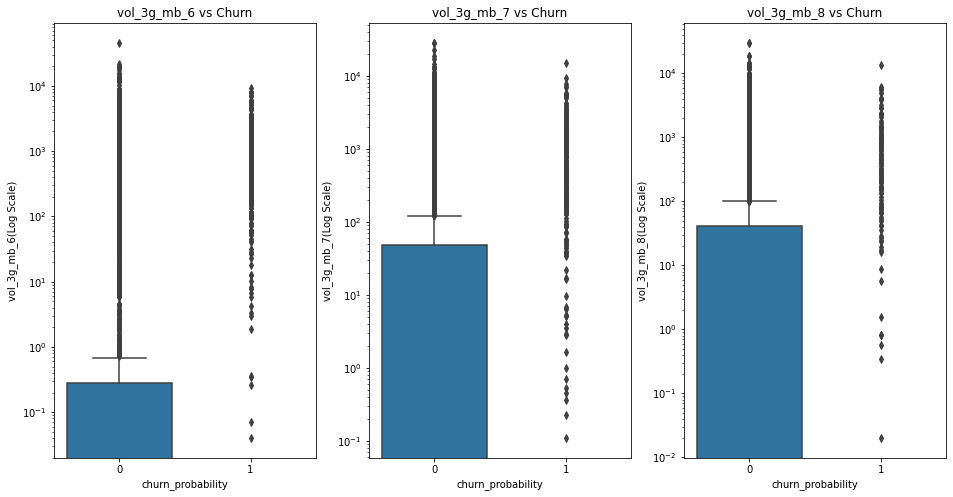

In [29]:
columns = ['vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8']
num_univariate_analysis(columns, 'log')

Customers who churned (Churn : 1)
+----+----------------+---------+-----------+--------------------+----------------------+
|    |   monthly_2g_6 |   count |   percent |   cumulative_count |   cumulative_percent |
|----+----------------+---------+-----------+--------------------+----------------------|
|  0 |              0 |    1799 | 94.9842   |               1799 |              94.9842 |
|  1 |              1 |      86 |  4.54065  |               1885 |              99.5248 |
|  2 |              2 |       7 |  0.369588 |               1892 |              99.8944 |
|  3 |              4 |       2 |  0.105597 |               1894 |             100      |
+----+----------------+---------+-----------+--------------------+----------------------+ 

+----+----------------+---------+-----------+--------------------+----------------------+
|    |   monthly_2g_7 |   count |   percent |   cumulative_count |   cumulative_percent |
|----+----------------+---------+-----------+-------------------

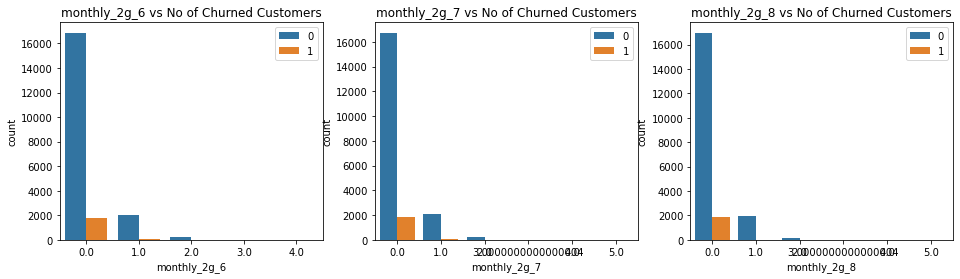

In [30]:
columns = ['monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8']
cat_univariate_analysis(columns)

Customers who churned (Churn : 1)
+----+----------------+---------+------------+--------------------+----------------------+
|    |   monthly_3g_6 |   count |    percent |   cumulative_count |   cumulative_percent |
|----+----------------+---------+------------+--------------------+----------------------|
|  0 |              0 |    1711 | 90.3379    |               1711 |              90.3379 |
|  1 |              1 |     132 |  6.96938   |               1843 |              97.3073 |
|  2 |              2 |      34 |  1.79514   |               1877 |              99.1024 |
|  3 |              3 |      10 |  0.527983  |               1887 |              99.6304 |
|  4 |              5 |       3 |  0.158395  |               1890 |              99.7888 |
|  5 |              4 |       3 |  0.158395  |               1893 |              99.9472 |
|  6 |              6 |       1 |  0.0527983 |               1894 |             100      |
+----+----------------+---------+------------+----------

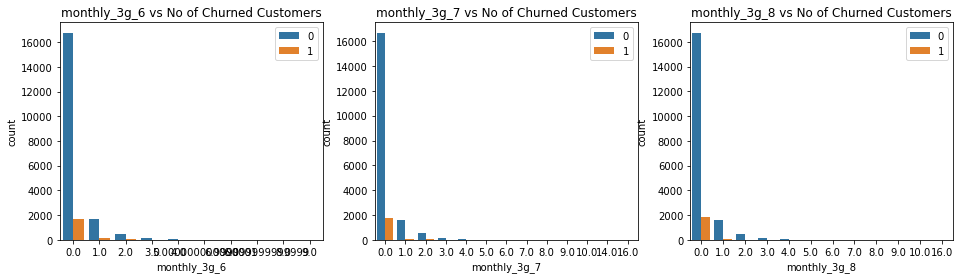

In [31]:
columns = ['monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8']
cat_univariate_analysis(columns)

# 3. Data Preparation and Transformation

## 3.1 Derived Metrics

In [32]:
#Usage 
df_high_val_cust['delta_vol_2g'] = df_high_val_cust['vol_2g_mb_8'] - (df_high_val_cust['vol_2g_mb_6'].add(df_high_val_cust['vol_2g_mb_7'])).div(2)
df_high_val_cust['delta_vol_3g'] = df_high_val_cust['vol_3g_mb_8'] - (df_high_val_cust['vol_3g_mb_6'].add(df_high_val_cust['vol_3g_mb_7'])).div(2)
df_high_val_cust['delta_total_og_mou'] = df_high_val_cust['total_og_mou_8'] - (df_high_val_cust['total_og_mou_6'].add(df_high_val_cust['total_og_mou_7'])).div(2)
df_high_val_cust['delta_total_ic_mou'] = df_high_val_cust['total_ic_mou_8'] - (df_high_val_cust['total_ic_mou_6'].add(df_high_val_cust['total_ic_mou_7'])).div(2)
df_high_val_cust['delta_vbc_3g'] = df_high_val_cust['aug_vbc_3g'] - (df_high_val_cust['jun_vbc_3g'].add(df_high_val_cust['jul_vbc_3g'])).div(2)

# Revenue 
df_high_val_cust['delta_arpu'] = df_high_val_cust['arpu_8'] - (df_high_val_cust['arpu_6'].add(df_high_val_cust['arpu_7'])).div(2)
df_high_val_cust['delta_total_rech_amt'] = df_high_val_cust['total_rech_amt_8'] -(df_high_val_cust['total_rech_amt_6'].add(df_high_val_cust['total_rech_amt_7'])).div(2)

In [33]:
df_high_val_cust.drop(columns=[
 'vol_2g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7',
  'vol_3g_mb_8'  , 'vol_3g_mb_6', 'vol_3g_mb_7' ,
    'total_og_mou_8','total_og_mou_6', 'total_og_mou_7', 
    'total_ic_mou_8','total_ic_mou_6', 'total_ic_mou_7',
    'aug_vbc_3g','jun_vbc_3g','jul_vbc_3g',
    'arpu_8','arpu_6','arpu_7',
    'total_rech_amt_8', 'total_rech_amt_6', 'total_rech_amt_7'
    
], inplace=True)

In [34]:
#Split the data in X and y
y = df_high_val_cust.pop('churn_probability').astype(int)
X = df_high_val_cust

X.shape, y.shape

((21000, 111), (21000,))

Splitting train and test data to avoid any contamination of the test data

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state =42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14700, 111), (6300, 111), (14700,), (6300,))

In [36]:
X_train.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,...,sachet_3g_8,aon,arpu_Gphase,delta_vol_2g,delta_vol_3g,delta_total_og_mou,delta_total_ic_mou,delta_vbc_3g,delta_arpu,delta_total_rech_amt
50711,1188.63,795.16,1001.68,266.84,503.46,585.14,0.00,0.0,0.0,0.00,...,0.0,184.0,731.2670,0.000,0.000,216.430,-6.940,0.000,215.9490,281.5
61180,246.13,74.29,28.29,670.19,339.58,69.41,36.06,0.0,0.0,112.49,...,0.0,2108.0,719.0150,-0.010,416.675,-511.145,-7.680,-7.600,-142.2140,-74.0
26132,80.04,116.93,218.86,349.38,230.28,526.83,0.00,0.0,0.0,0.00,...,0.0,2418.0,969.1830,21.275,-1025.905,357.370,81.775,-306.070,-192.2670,-276.0
18564,41.18,61.08,25.96,226.73,283.66,245.76,0.00,0.0,0.0,0.00,...,0.0,391.0,352.1395,0.000,0.000,-34.595,-96.370,0.000,-83.5295,-53.5
62770,10.03,237.23,450.96,230.38,187.58,151.69,0.00,0.0,0.0,0.00,...,0.0,250.0,561.7200,-80.145,-714.180,268.990,233.015,-603.775,226.3070,340.0


## 3.2 Outlier Detection and Treatment

<AxesSubplot:>

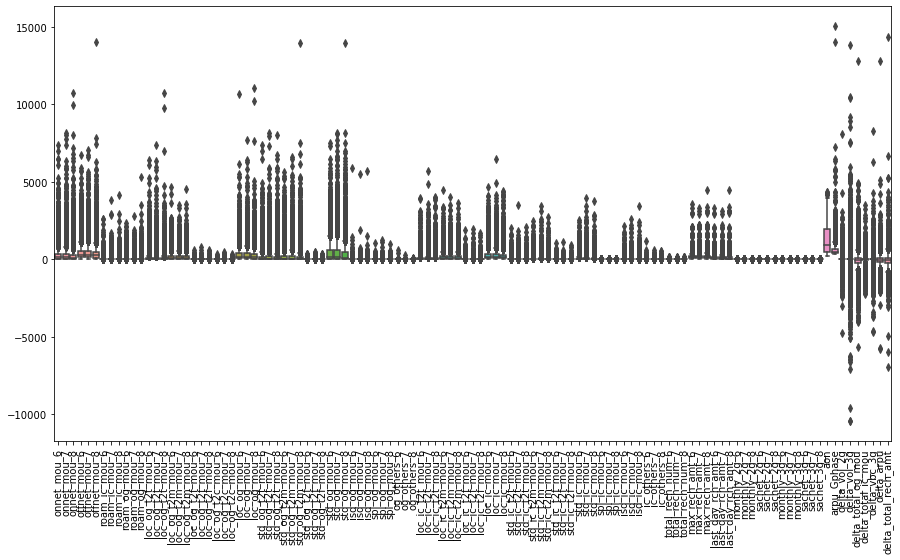

In [37]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.boxplot(data = X_train)

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [38]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [39]:
X_train_filtered = X_train.apply(cap_outliers, axis=0)

<AxesSubplot:>

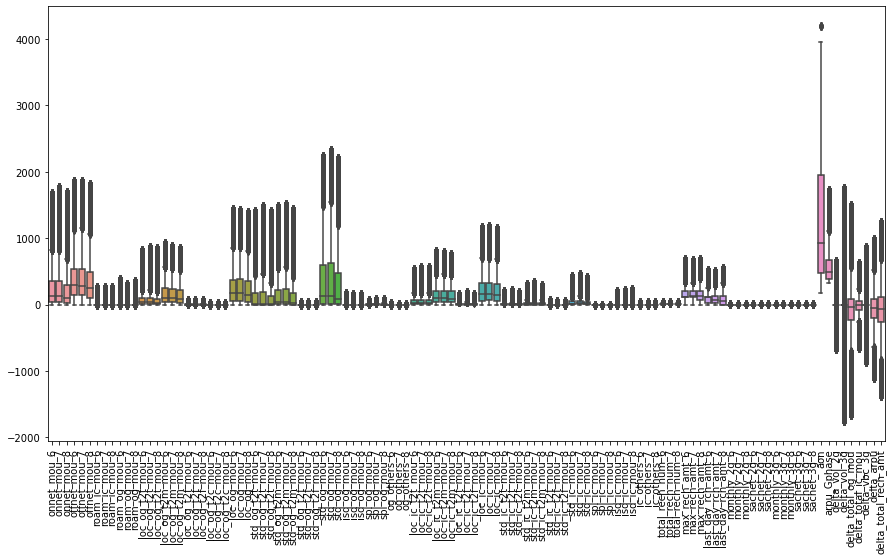

In [40]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.boxplot(data = X_train_filtered)

In [41]:
# function to correlate variables
def correlation(dataframe) : 
    
    columnsForAnalysis = set(dataframe.columns.values) - {'churn_probability'}
    cor0=dataframe[columnsForAnalysis].corr()
    type(cor0)
    cor0.where(np.triu(np.ones(cor0.shape),k=1).astype(np.bool))
    cor0=cor0.unstack().reset_index()
    cor0.columns=['VAR1','VAR2','CORR']
    cor0.dropna(subset=['CORR'], inplace=True)
    cor0.CORR=round(cor0['CORR'],2)
    cor0.CORR=cor0.CORR.abs()
    cor0.sort_values(by=['CORR'],ascending=False)
    cor0=cor0[~(cor0['VAR1']==cor0['VAR2'])]

    # removing duplicate correlations
    cor0['pair'] = cor0[['VAR1', 'VAR2']].apply(lambda x: '{}-{}'.format(*sorted((x[0], x[1]))), axis=1)
    
    cor0 = cor0.drop_duplicates(subset=['pair'], keep='first')
    cor0 = cor0[['VAR1', 'VAR2','CORR']]
    return pd.DataFrame(cor0.sort_values(by=['CORR'],ascending=False))

In [42]:
# Correlations for Churn : 0  - non churn customers
# Absolute values are reported 
#pd.set_option('precision', 2)
cor_0 = correlation(non_churned_customers)

# filtering for correlations >= 70%
condition = cor_0['CORR'] > 0.7
cor_0 = cor_0[condition]
cor_0.style.background_gradient(cmap='GnBu').hide_index()

VAR1,VAR2,CORR
total_rech_amt_8,arpu_8,0.960000
isd_og_mou_6,isd_og_mou_7,0.960000
isd_og_mou_8,isd_og_mou_6,0.960000
isd_og_mou_8,isd_og_mou_7,0.960000
arpu_7,total_rech_amt_7,0.950000
arpu_6,total_rech_amt_6,0.940000
arpu_7,arpu_Gphase,0.930000
arpu_Gphase,arpu_6,0.920000
total_ic_mou_6,loc_ic_mou_6,0.910000
total_rech_amt_7,arpu_Gphase,0.900000


In [43]:
# Correlations for Churn : 1  - churned customers
# Absolute values are reported 
#pd.set_option('precision', 2)
cor_1 = correlation(churned_customers)

# filtering for correlations >= 70%
condition = cor_1['CORR'] > 0.7
cor_1 = cor_1[condition]
cor_1.style.background_gradient(cmap='GnBu').hide_index()

VAR1,VAR2,CORR
std_og_t2t_mou_7,onnet_mou_7,0.960000
total_rech_amt_8,arpu_8,0.950000
total_og_mou_7,std_og_mou_7,0.950000
arpu_7,total_rech_amt_7,0.940000
total_og_mou_8,std_og_mou_8,0.940000
offnet_mou_7,std_og_t2m_mou_7,0.930000
total_og_mou_6,std_og_mou_6,0.930000
std_og_t2m_mou_6,offnet_mou_6,0.930000
onnet_mou_6,std_og_t2t_mou_6,0.920000
onnet_mou_8,std_og_t2t_mou_8,0.920000


## 3.3 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [44]:
#X_train_filtered = X_train
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train_filtered)

<AxesSubplot:xlabel='churn_probability', ylabel='Count'>

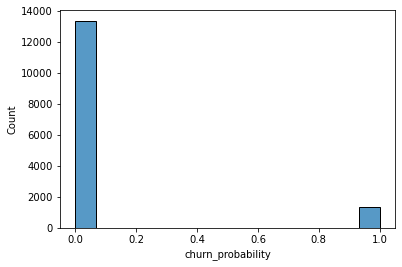

In [45]:
#Distribution for the churn probability
sns.histplot(y_train)

## 3.4 SMOTE Transformation
As there is high imbalance in the churn_probability classes, we will perform SMOTE transformation for oversampling.

In [46]:
smote = SMOTE(random_state = 42)
X_train_samp, y_train_samp = smote.fit_resample(X_train_scaled, y_train)
X_train_samp.shape

(26748, 111)

## 3.5 PCA Transformation

<AxesSubplot:>

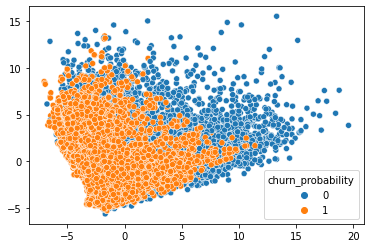

In [47]:
pca = PCA(random_state=42)
pca_components = pca.fit_transform(X_train_samp)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train_samp)

<AxesSubplot:>

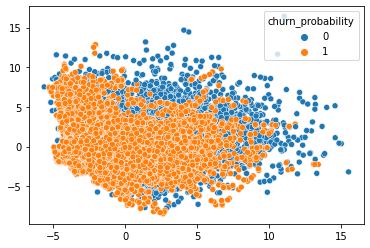

In [48]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train_samp)

In [49]:
variance_cumu = np.cumsum(pca.explained_variance_ratio_)
print(variance_cumu)

[0.11826971 0.19386432 0.25355171 0.30838966 0.35756356 0.40050054
 0.43805607 0.47055918 0.49663133 0.51934955 0.53912214 0.55839025
 0.57714776 0.59466107 0.61161495 0.62714307 0.64229972 0.65637491
 0.66979513 0.68264049 0.69455385 0.7062984  0.71776777 0.72868218
 0.73884633 0.74849316 0.75767545 0.76667371 0.7754351  0.78395241
 0.79235393 0.8005814  0.80864218 0.81614059 0.82348242 0.83065028
 0.83739699 0.84407187 0.85037814 0.85637788 0.86216676 0.86772132
 0.8731518  0.87844578 0.88336171 0.88794208 0.8924664  0.89661524
 0.90058581 0.90443554 0.90825514 0.91201261 0.91567344 0.91927469
 0.92277779 0.92616838 0.92942698 0.93258081 0.93568917 0.93871663
 0.94167209 0.9445967  0.94742166 0.95015865 0.9528217  0.95535954
 0.95785343 0.96025355 0.96264219 0.96492122 0.96710632 0.96926134
 0.97139018 0.9734852  0.97542014 0.97727175 0.9790738  0.98070734
 0.98230506 0.98384438 0.98529728 0.9867169  0.98808975 0.98934613
 0.99055029 0.99170309 0.99280305 0.99385384 0.99486522 0.9956

Text(0, 0.5, 'Cumulative Variance')

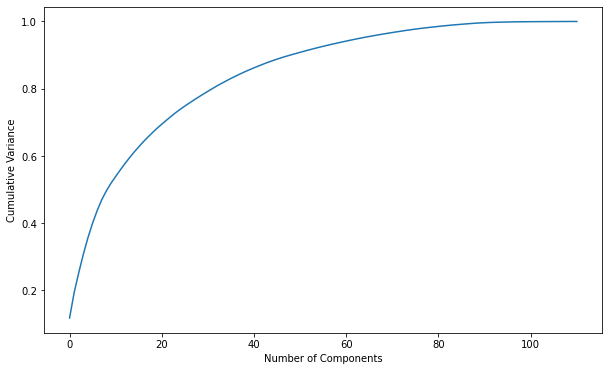

In [50]:
# Plotting scree plot
fig = plt.figure(figsize = (10,6))
plt.plot(variance_cumu)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

*As 90% of the variance is explained by almost 60 features, we will select the optimal value for n_components = 60*

In [51]:
# Instantiate PCA with 60 components
pca_final = IncrementalPCA(n_components=60)

In [52]:
# Fit and transform the X_train
X_train_pca = pca_final.fit_transform(X_train_samp)
X_train_pca.shape

(26748, 60)

# 4. Model Building and Evaluation

## 4.1 Logistics Regression with PCA

In [53]:
def evaluate_train_data(classifier, X_train, y_train):
    y_train_pred = classifier.predict(X_train) 
    print("Train set Performance")
    print('-------------Accuracy------------')
    print(accuracy_score(y_train, y_train_pred))
    print('-------------Precision------------')
    print(precision_score(y_train, y_train_pred))
    print('-------------Recall------------')
    print(recall_score(y_train, y_train_pred))
    print('-------------Confusion Matrix------------')
    print(confusion_matrix(y_train, y_train_pred)) 
    

In [54]:
def evaluate_test_data(classifier, X_test, y_test):
    y_test_pred = classifier.predict(X_test) 
    print("Test set Performance")
    print('-------------Accuracy------------')
    print(accuracy_score(y_test, y_test_pred))
    print('-------------Precision------------')
    print(precision_score(y_test, y_test_pred))
    print('-------------Recall------------')
    print(recall_score(y_test, y_test_pred))
    print('-------------Confusion Matrix------------')
    print(confusion_matrix(y_test, y_test_pred)) 

In [55]:
X_train_resamp = X_train_pca
y_train_resamp = y_train_samp

In [56]:
X_test_scaled = scale.transform(X_test)
X_test_pca = pca_final.transform(X_test_scaled)

In [57]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(X_train_resamp, y_train_resamp)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [58]:
evaluate_train_data(lr, X_train_resamp, y_train_resamp)

Train set Performance
-------------Accuracy------------
0.8535217586361598
-------------Precision------------
0.8407321994811184
-------------Recall------------
0.8722895169732316
-------------Confusion Matrix------------
[[11164  2210]
 [ 1708 11666]]


In [59]:
evaluate_test_data(lr, X_test_pca, y_test )

Test set Performance
-------------Accuracy------------
0.8250793650793651
-------------Precision------------
0.31636863823933975
-------------Recall------------
0.8098591549295775
-------------Confusion Matrix------------
[[4738  994]
 [ 108  460]]


## 4.2 Random Forest with PCA

In [60]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [61]:
param_grid = {
    'max_depth': [10,15,20,25],
    'max_features': [20, 30, 40],
    'min_samples_leaf': [10,20, 50],
    'min_samples_split': [10,20,50]
}

In [62]:
grid_search = GridSearchCV(estimator= rf, param_grid = param_grid,
                          cv=3, n_jobs=-1, verbose=1, scoring = 'accuracy' )

In [63]:
grid_search.fit(X_train_resamp , y_train_resamp)

In [64]:
rf_best = grid_search.best_estimator_
rf_best

In [65]:
rf_final = RandomForestClassifier(max_depth=20, max_features=40,
                       n_estimators=200, n_jobs=-1, random_state=42)
rf_final.fit(X_train_resamp, y_train_resamp)

RandomForestClassifier(max_depth=20, max_features=40, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [66]:
evaluate_train_data(rf_final, X_train_resamp, y_train_resamp)

Train set Performance
-------------Accuracy------------
0.9848960669956632
-------------Precision------------
0.9706778922920598
-------------Recall------------
1.0
-------------Confusion Matrix------------
[[12970   404]
 [    0 13374]]


In [67]:
evaluate_test_data(rf_final, X_test_pca, y_test )

Test set Performance
-------------Accuracy------------
0.9017460317460317
-------------Precision------------
0.46153846153846156
-------------Recall------------
0.5387323943661971
-------------Confusion Matrix------------
[[5375  357]
 [ 262  306]]


## 4.3 SVM with PCA

In [68]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-1,1e-2, 1e-3], 'C': [1, 10, 100]}]

# specify model
model = svm.SVC(kernel="rbf")

# set up GridSearchCV()
model_cv_svm = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True) 

In [69]:
# fit the model
model_cv_svm.fit(X_train_resamp, y_train_resamp)

In [70]:
best_score = model_cv_svm.best_score_
best_hyperparams = model_cv_svm.best_params_

In [71]:
final_svm_model = svm.SVC(C=10, gamma=0.1, kernel="rbf")
final_svm_model.fit(X_train_resamp, y_train_resamp)

SVC(C=10, gamma=0.1)

In [72]:
evaluate_train_data(final_svm_model,X_train_resamp, y_train_resamp)

Train set Performance
-------------Accuracy------------
0.999925228054434
-------------Precision------------
0.9998504784688995
-------------Recall------------
1.0
-------------Confusion Matrix------------
[[13372     2]
 [    0 13374]]


In [73]:
evaluate_test_data(final_svm_model,X_test_pca, y_test)

Test set Performance
-------------Accuracy------------
0.9128571428571428
-------------Precision------------
0.54337899543379
-------------Recall------------
0.20950704225352113
-------------Confusion Matrix------------
[[5632  100]
 [ 449  119]]


## 4.4 XGBoost with PCA

In [74]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 5

# specify range of hyperparameters
param_grid = {'learning_rate': [0.1,0.2,0.3], 
             'subsample': [0.3,0.4,0.5]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'accuracy', # accuracy
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True) 

In [75]:
# fit the model
model_cv.fit(X_train_resamp, y_train_resamp) 

In [76]:
best_hyperparams = model_cv.best_params_
best_hyperparams

In [77]:
params = {'learning_rate': 0.3,
          'subsample':0.5,
         'objective':'binary:logistic'}

# fit model on training data
xgb_model = XGBClassifier(params = params,max_depth=12, n_estimators=200)
xgb_model.fit(X_train_resamp, y_train_resamp)

[23:24:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1,
              params={'learning_rate': 0.3, 'objective': 'binary:logistic',
                      'subsample': 0.5},
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [78]:
evaluate_train_data(xgb_model,X_train_resamp, y_train_resamp)

Train set Performance
-------------Accuracy------------
1.0
-------------Precision------------
1.0
-------------Recall------------
1.0
-------------Confusion Matrix------------
[[13374     0]
 [    0 13374]]


In [79]:
evaluate_test_data(xgb_model,X_test_pca, y_test)

Test set Performance
-------------Accuracy------------
0.9157142857142857
-------------Precision------------
0.5352380952380953
-------------Recall------------
0.49471830985915494
-------------Confusion Matrix------------
[[5488  244]
 [ 287  281]]


# 5. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [80]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [81]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


In [82]:
unseen['arpu_Gphase'] = (unseen['arpu_6'] + unseen['arpu_7'])/2

In [83]:
# Calling the Scaling function
scalar = MinMaxScaler()

# Scaling and transforming the data for the columns that are numerical
unseen[num_col]=scalar.fit_transform(unseen[num_col])

# Calling the KNN Imputer function
knn=KNNImputer(n_neighbors=3)

# Imputing the NaN values using KNN Imputer
unseen_knn = pd.DataFrame(knn.fit_transform(unseen[num_col]))


In [84]:
unseen[num_col]=scalar.inverse_transform(unseen_knn)

In [85]:

#Usage 
unseen['delta_vol_2g'] = unseen['vol_2g_mb_8'] - (unseen['vol_2g_mb_6'].add(unseen['vol_2g_mb_7'])).div(2)
unseen['delta_vol_3g'] = unseen['vol_3g_mb_8'] - (unseen['vol_3g_mb_6'].add(unseen['vol_3g_mb_7'])).div(2)
unseen['delta_total_og_mou'] = unseen['total_og_mou_8'] - (unseen['total_og_mou_6'].add(unseen['total_og_mou_7'])).div(2)
unseen['delta_total_ic_mou'] = unseen['total_ic_mou_8'] - (unseen['total_ic_mou_6'].add(unseen['total_ic_mou_7'])).div(2)
unseen['delta_vbc_3g'] = unseen['aug_vbc_3g'] - (unseen['jun_vbc_3g'].add(unseen['jul_vbc_3g'])).div(2)

# Revenue
unseen['delta_arpu'] = unseen['arpu_8'] - (unseen['arpu_6'].add(unseen['arpu_7'])).div(2)
unseen['delta_total_rech_amt'] = unseen['total_rech_amt_8'] -(unseen['total_rech_amt_6'].add(unseen['total_rech_amt_7'])).div(2)

In [86]:
new_vars = X_train.columns
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

(30000, 111)

In [87]:
test_scaled = scale.transform(submission_data)

In [88]:
test_pca = pca_final.transform(test_scaled)
test_pca.shape

(30000, 60)

__As XG Boost gives the highest accuracy on test data, we will perform the prediction for unseen data on XGBClassifier model__

In [89]:
unseen['churn_probability'] = xgb_model.predict(test_pca)

Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [90]:
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [91]:
output.to_csv('submission.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.

# 6. Feature selection and Recommendations

In [92]:
rf_imp = rf_final
rf_imp.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=20, max_features=40, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [93]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf_imp.feature_importances_})
feature_importances = feature_importances.nlargest(10, 'importance')

<BarContainer object of 10 artists>

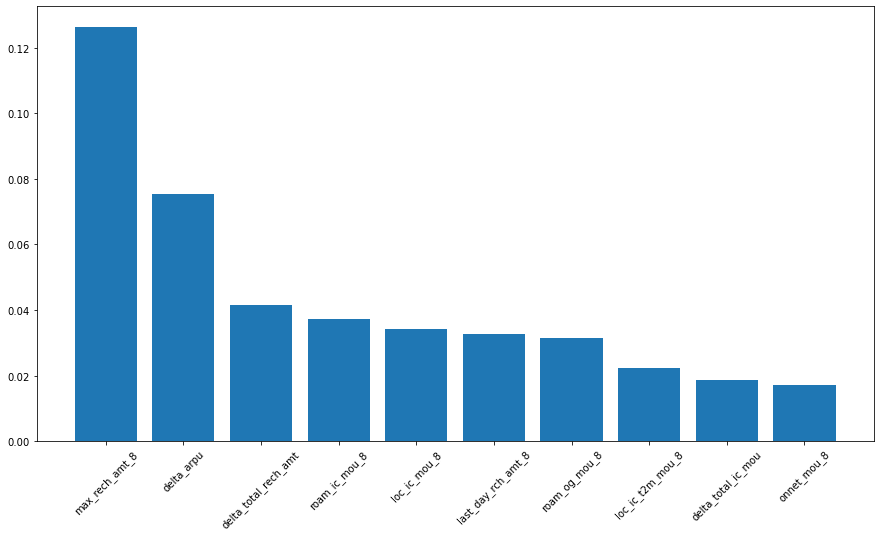

In [94]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

## Recommentations

#### Business Insights
- Customers with around 4 years of tenure are more likely to churn and company should concentrate more on that segment by rolling out new schems to that group.

- Average revenue per user seems to be most important feature in determining churn prediction.

- Incoming and Outgoing Calls on romaing and local in action phase are strong indicators of churn behaviour

- Total incoming calls from any network provides a strong indicator of churn behaviour.

- Better 2G/3G area coverage where 2G/3G services are not good, it's strong indicator of churn behaviour.

#### Following features should be monitored closely to predict whether a high-value customer will churn or not 
- Recharge amout in action phase 
- Decline in the ARPU (Average Revenue Per User) from good phase to action phase.
- Decline in Total recharge amount from good phase to action phase.
- Decline in minute of usage of any incoming calls(Roaming, local) and outgoing calls in action phase.